## Q-performance comparison

In [1]:
import sys
import os 
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

from learning.collections_env.collections_env import CollectionsEnv, MAX_ACCOUNT_BALANCE
from learning.utils.wrappers import DiscretizedActionWrapper, StateNormalization
from learning.policies.dqn import DQNAgent, DefaultConfig
from learning.utils import misc
from learning.policies.discrete_optimal_policy import DiscretePolicyConstructor
from dcc import Parameters, AAV, OAV

from tqdm import tqdm
from joblib import delayed, Parallel

import logging
import numpy as np
import pickle
import copy
from itertools import product
#import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K


from IPython.display import HTML, clear_output

import matplotlib.pyplot as plt
# import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from learning.utils.load_experiment import LoadExperiment
from learning.policy_pricer import policy_pricer, cython_pricer_optimized

In [2]:
from learning.utils.load_experiment import LoadExperiment
ldr = LoadExperiment(backup=True)

In [3]:
cps = ldr.list_checkpoints('SPLINE-1', 0)
ag = ldr.load_agent_from_path(cps[5])

[WARNING] [2021-03-25 12:09:24,357] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


In [4]:
ag.main_net.summary()

Model: "combined"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 66)]              0         
_________________________________________________________________
tf_op_layer_strided_slice (T (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 192       
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________


In [5]:
ww, ll, p, z = policy_pricer.create_map(ag, w_points = 100, l_points=100, lam_lim=5, larger_offset=True)

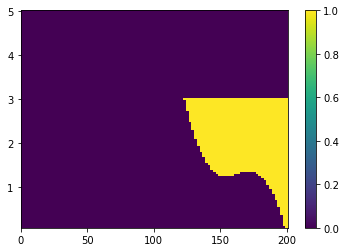

In [6]:
plt.pcolormesh(ww, ll, p, shading='auto')
plt.colorbar()

Lets plot individual weights progress:

In [7]:
AGENTS = os.listdir(os.path.join(ldr.repo, 'models'))
chcps = ldr.list_checkpoints(AGENTS[0], log_num=0)
agent = ldr.load_agent_from_path(chcps[0])

[WARNING] [2021-03-25 12:09:25,425] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


In [8]:
np.sum([np.linalg.norm(weight.numpy()) for weight in agent.main_net.trainable_weights])

60.898853

In [13]:
logging.getLogger().setLevel(logging.ERROR)

def calc_checkpoint_weights(checkpoint):
    agent = ldr.load_agent_from_path(checkpoint);
    sys.stdout.flush()
    return np.sum([np.linalg.norm(weight.numpy()) for weight in agent.main_net.trainable_weights])

def w_calc_agent(ldr, name, log_num=0):
    checkpoint_paths = ldr.list_checkpoints(name, log_num=log_num)
    vals = np.zeros(len(checkpoint_paths))
    for i, path in enumerate(tqdm(checkpoint_paths)):
    # for i, path in enumerate(checkpoint_paths):
        vals[i] = calc_checkpoint_weights(path)
    return vals


def w_calc_agent_parallel(ldr, name, n_jobs, log_num=0):
    checkpoint_paths = ldr.list_checkpoints(name, log_num=log_num)
#     vals = np.zeros(len(checkpoint_paths))
#     stds = np.zeros(len(checkpoint_paths))
    rets = Parallel(n_jobs=n_jobs)(delayed(calc_checkpoint_weights)(path) for path in checkpoint_paths)
    return rets

def weights_names(ldr, names, n_jobs=20, log_num=0):
    results = {}
    for i, name in enumerate(tqdm(names)):
        if n_jobs>1:
            results[name] =  w_calc_agent_parallel(ldr, name, log_num=0, n_jobs=n_jobs)
        else:
            results[name] = w_calc_agent(ldr, name, log_num=0)
    return results

In [14]:
w_norms_dqn = w_calc_agent(ldr, 'DQN-0', log_num=0)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [03:12<00:00,  2.59it/s]


In [17]:
w_norms_constr = w_calc_agent(ldr, 'MONOSPLINE-0', log_num=0)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:46<00:00,  3.01it/s]


In [18]:
w_norms_naive = w_calc_agent(ldr, 'SPLINE-0', log_num=0)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:48<00:00,  2.96it/s]


In [24]:
w_norms_200p = w_calc_agent(ldr, 'DQN200p-0', log_num=0)

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:36<00:00,  2.70it/s]


Text(0, 0.5, '$\\frac{||w_i||_2}{||w_50000||_2}$')

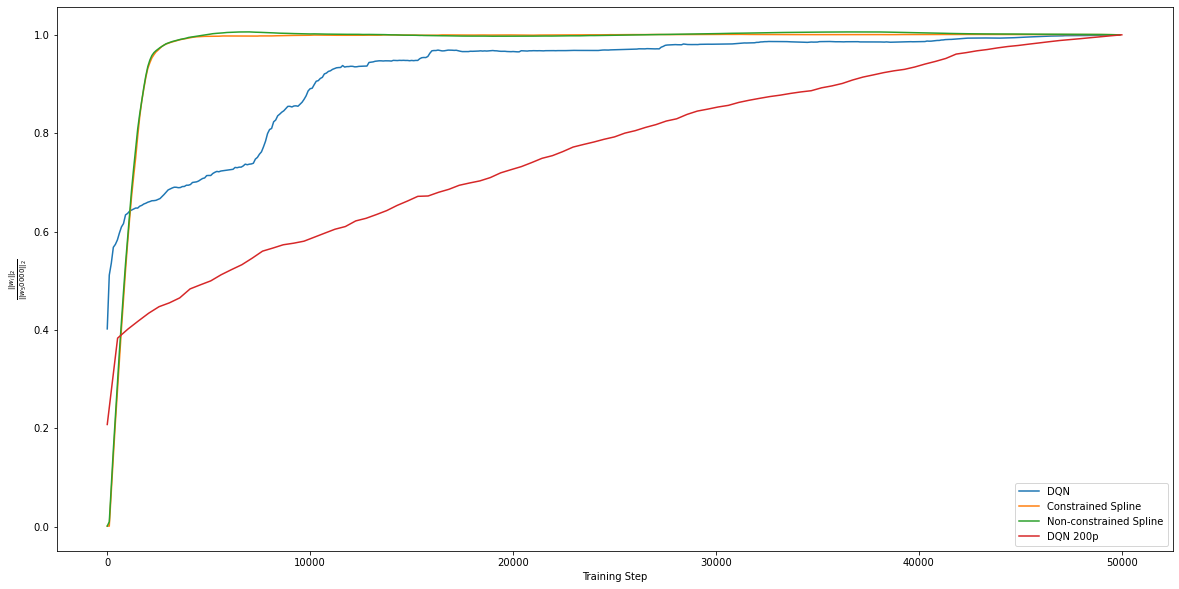

In [31]:
fig, ax = plt.subplots(figsize=(20,10))
x = np.arange(0, 50000, 100)
x2 = np.linspace(0, 50000, 99)
ax.plot(x, w_norms_dqn / w_norms_dqn[-1])
ax.plot(x, w_norms_naive / w_norms_naive[-1])
ax.plot(x, w_norms_constr / w_norms_constr[-1])
ax.plot(x2, w_norms_200p / w_norms_200p[-1])
ax.legend(['DQN', 'Constrained Spline', 'Non-constrained Spline', 'DQN 200p'])
ax.set_xlabel('Training Step')
ax.set_ylabel(r'$\frac{||w_i||_2}{||w_50000||_2}$')

Lets evaluate the learning performance:

In [7]:
n_acc = 100
llb = 0.2
lub = 1.2
wlb = 50.
wub = 200.
portfolio = np.array([[np.random.uniform(llb, lub), np.random.uniform(wlb, wub)] for _ in range(n_acc)])

Text(0.5, 1.0, 'portfolio')

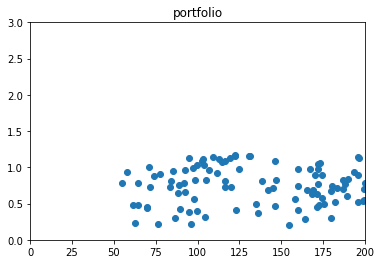

In [8]:
fig, ax = plt.subplots()
ax.scatter(portfolio[:, 1], portfolio[:, 0])
ax.set_ylim([0, 3])
ax.set_xlim([0, 200])
ax.set_title('portfolio')

In [8]:
logging.getLogger().setLevel(logging.ERROR)

def calc_checkpoint_value(accs, checkpoint, niter= 5000, w_points = 100, l_points=100, lam_lim=5):
    res = np.zeros(len(accs), dtype='float64')
    agent = ldr.load_agent_from_path(checkpoint);
    sys.stdout.flush()
    ww, ll, p, z = policy_pricer.create_map(agent, w_points = w_points, l_points=l_points, lam_lim=lam_lim, larger_offset=True)
    for i, acc in enumerate(accs):
        vals = np.asarray(cython_pricer_optimized.value_account(acc, ww, ll, p, cython_pricer_optimized.convert_params_obj(agent.env.params), agent.env.env.action_bins, n_iterations=niter))
        res[i] = np.mean(vals)
    return np.mean(res), np.std(res)

def calc_agent(ldr, name, accs, log_num=0, niter= 5000, w_points = 100, l_points=100, lam_lim=5):
    checkpoint_paths = ldr.list_checkpoints(name, log_num=log_num)
    vals = np.zeros(len(checkpoint_paths))
    stds = np.zeros(len(checkpoint_paths))
    for i, path in enumerate(tqdm(checkpoint_paths)):
        vals[i], stds[i] = calc_checkpoint_value(accs, path, niter=niter, w_points = w_points, l_points=l_points, lam_lim=lam_lim)
    return vals, stds


def calc_agent_parallel(ldr, name, accs, log_num=0, niter= 5000, w_points = 100, l_points=100, lam_lim=5, n_jobs=20):
    checkpoint_paths = ldr.list_checkpoints(name, log_num=log_num)
#     vals = np.zeros(len(checkpoint_paths))
#     stds = np.zeros(len(checkpoint_paths))
    rets = Parallel(n_jobs=n_jobs)(delayed(calc_checkpoint_value)(accs, path, niter=niter, w_points = w_points, l_points=l_points, lam_lim=lam_lim) for path in checkpoint_paths)
    return rets

def value_names(ldr, names, accs, n_jobs=20, log_num=0, niter= 5000, w_points = 100, l_points=100, lam_lim=5):
    results = {}
    for i, name in enumerate(tqdm(names)):
        if n_jobs>1:
            results[name] = (calc_agent_parallel(ldr, name, accs, log_num=log_num, niter= niter, w_points = w_points, l_points=l_points, lam_lim=lam_lim, n_jobs=n_jobs))
        else:
            results[name] = (calc_agent(ldr, name, accs, log_num=log_num, niter=niter, w_points = w_points, l_points=l_points, lam_lim=lam_lim, n_jobs=n_jobs))
        save_obj(results, 'MC_5000_200params_evaluated')
    return results
            
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [13]:
AGENTS = os.listdir(os.path.join(ldr.repo, 'models'))
#AGENTS_200p = [a for a in AGENTS if 'DQN200p' in a]

In [16]:
# AGENTS = ['DQN-0', 'SPLINE-0', 'MONOSPLINE-0']
# AGENTS = os.listdir(os.path.join(ldr.repo, 'models'))[1:]

# CAREFUL - NUMBER OF CHECKPOINTS CAN BE MISSMATCHED!
vals = value_names(ldr, AGENTS, portfolio, n_jobs=45, log_num=0, niter= 5000, w_points = 100, l_points=100, lam_lim=5)

100%|█████████████████████████████████████████████████████████████████████████████| 40/40 [17:37:25<00:00, 1586.14s/it]


In [23]:
# THIS IS HOW TO LOOK IT UP LATER !
dqns = [ l for k,l in vals.items() if k.startswith('DQN200p')]
monosplines = [ l for k,l in vals.items() if k.startswith('SPLINE')]
bsplines = [ l for k,l in vals.items() if k.startswith('MONO')]

In [90]:
def process_plot_data_different_size(vals, key: str):
    data_from_key = dqns = [ l for k,l in vals.items() if k.startswith(key)]
    avgs = np.zeros((100, len(data_from_key)), dtype='float64')
    for i, teration in enumerate(data_from_key):
        d1 = [data[0] for data in data_from_key[i]]
        avgs[:len(d1), i] = d1
    return avgs


In [91]:
data_from_key = dqns = [ l for k,l in vals.items() if k.startswith('DQN200p')]

In [92]:
np.mean(data_from_key[0],

SyntaxError: unexpected EOF while parsing (<ipython-input-92-e66af1743202>, line 1)

In [149]:
np.arange(0, 50000, 500).shape

(100,)

In [154]:
x_s = np.arange(0, 50000, 500)#ldr.list_checkpoints('DQN200p-0', 0, returntype='s')
placeholder = process_plot_data_different_size(vals, 'DQN200p')

In [157]:
np.mean(placeholder, axis=1).shape

(100,)

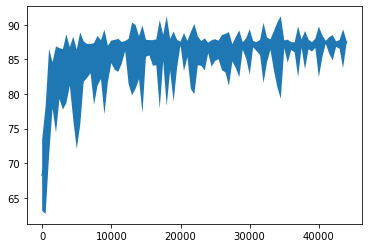

In [161]:
std_placeholder = np.std(placeholder[:-11], axis=1)
mean_placeholder = np.mean(placeholder[:-11], axis=1)
plt.plot(x_s[:-11], mean_placeholder)
plt.fill_between(x_s[:-11], mean_placeholder-std_placeholder, mean_placeholder+std_placeholder, alpha=)
# plt.plot(np.mean(placeholder, axis=1))

In [97]:
np.mean(portfolio, axis=0)

array([  0.73221404, 126.51868205])

In [239]:
def process_plot_data(vals, key: str):
    data_from_key = dqns = [ l for k,l in vals.items() if k.startswith(key)]
    avgs = np.zeros((len(data_from_key[0]), len(data_from_key)), dtype='float64')
    stds = np.zeros((len(data_from_key[0]), len(data_from_key)), dtype='float64')
    for i, teration in enumerate(data_from_key):
        avgs[:, i] = [data[0] for data in data_from_key[i]]
        stds[:, i] = [data[1] for data in data_from_key[i]]
    return avgs, stds

def plot_learning(names, vals, percentage=True, adhoc=True):
    fig, ax = plt.subplots(figsize=(20, 10))
    x = np.arange(0, 50000, 100)
    a_s = aav_portfolio(portfolio)
    ds = []
    if percentage:
        mean_pfolio = np.mean(portfolio, axis=0)[1]
    for i, name in enumerate(names):
        avgs, stds = process_plot_data(vals, name)
        if percentage:
            avgs = avgs/mean_pfolio * 100
            v_s = valus_opt / mean_pfolio * 100
            a_s = a_s / mean_pfolio * 100
        else:
            v_s = valus_opt
        stds = np.std(avgs, axis=1)
        avgs = np.mean(avgs, axis=1)
        ds.append((x, avgs))
        ax.plot(x, avgs)
        ax.fill_between(x, avgs-stds, avgs+stds, alpha=0.2)
    ax.legend(['DQN', 'Monotonic BSpline', 'BSpline'])
    ax.set_xlabel(['Learning steps'])
    ax.axhline(a_s, color='red', linestyle='--')
    ax.axhline(v_s, color='brown', linestyle='--')
    if percentage:
        ax.axhline(100, color='black', linestyle=':')
    if adhoc:
        if percentage:
            adj = -3
            adjusted = (placeholder[:-11]+adj) / mean_pfolio * 100
        else:
            adjusted= (placeholder[:-11]+adj)
        std_placeholder = np.std(adjusted, axis=1)
        mean_placeholder = np.mean(adjusted, axis=1)
        ax.plot(x_s[:-11], mean_placeholder)
        ax.fill_between(x_s[:-11], mean_placeholder-std_placeholder, mean_placeholder+std_placeholder, alpha=0.2)
        ds.append((x_s[:-11], mean_placeholder))
        # plt.plot(np.mean(placeholder, axis=1))
        if percentage:
            ax.set_ylabel('Collected % of Portfolio')
        else:
            ax.set_ylabel('Avg ammount collected from Portfolio')
        ax.set_xlabel('Training episode')
    return ds
        

def aav_portfolio(portf):
    aav = AAV(ag.env.params)
    values = np.zeros(len(portf))
    for i, value in enumerate(portf):
        values[i] = aav.u(value[0], value[1])
    return -np.mean(values)

def compute_v(portf):
    # probably taking max of a portfolio would be better here
    oav = OAV(ag.env.params, 200)
    oav.solve_v()
    values = np.zeros(len(portf))
    for i, value in enumerate(portf):
        values[i] = oav.v(value[0], value[1])
    return -np.mean(values)

# valus_opt = compute_v(portfolio)

In [253]:
v_s

89.72675389976288

In [241]:
 aav_portfolio(portfolio)

[INFO] [2021-03-18 13:54:52,923] [AAV] - Instantiated @ AAV


65.61563956119696

In [242]:
vals.keys()

dict_keys(['DQN-0', 'DQN-1', 'DQN-2', 'DQN-3', 'DQN-4', 'DQN-5', 'DQN-6', 'DQN-7', 'DQN-8', 'DQN-9', 'DQN200p-0', 'DQN200p-1', 'DQN200p-2', 'DQN200p-3', 'DQN200p-4', 'DQN200p-5', 'DQN200p-6', 'DQN200p-7', 'DQN200p-8', 'DQN200p-9', 'MONOSPLINE-0', 'MONOSPLINE-1', 'MONOSPLINE-2', 'MONOSPLINE-3', 'MONOSPLINE-4', 'MONOSPLINE-5', 'MONOSPLINE-6', 'MONOSPLINE-7', 'MONOSPLINE-8', 'MONOSPLINE-9', 'SPLINE-0', 'SPLINE-1', 'SPLINE-2', 'SPLINE-3', 'SPLINE-4', 'SPLINE-5', 'SPLINE-6', 'SPLINE-7', 'SPLINE-8', 'SPLINE-9'])

[INFO] [2021-03-18 13:54:59,331] [AAV] - Instantiated @ AAV


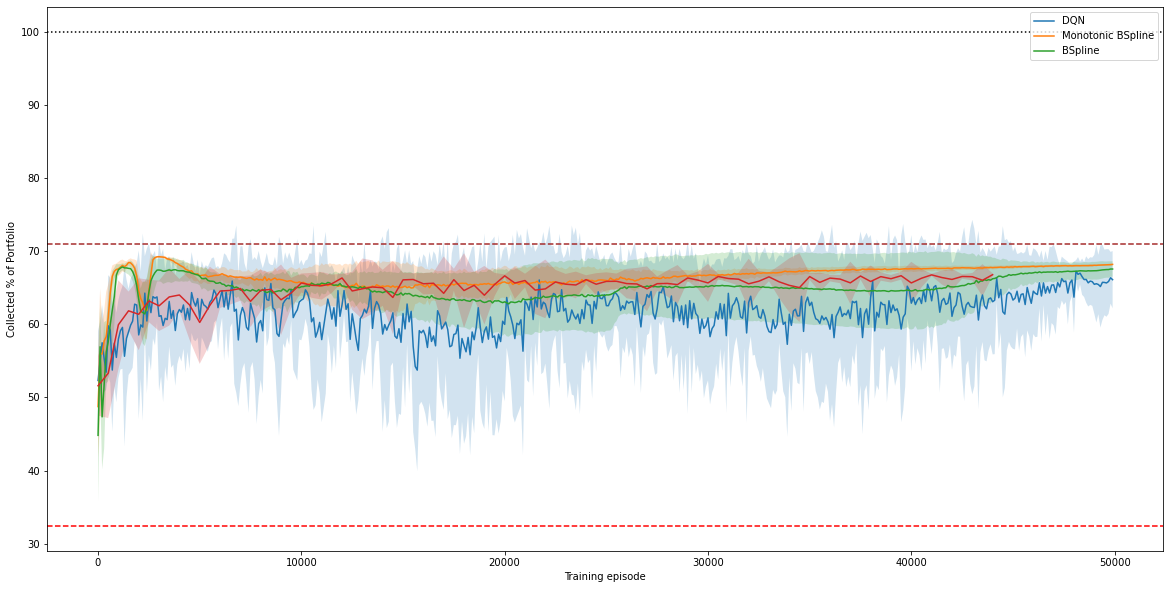

In [243]:
ds = plot_learning(['DQN-', 'SPLINE', 'MONO'], vals, percentage=True)


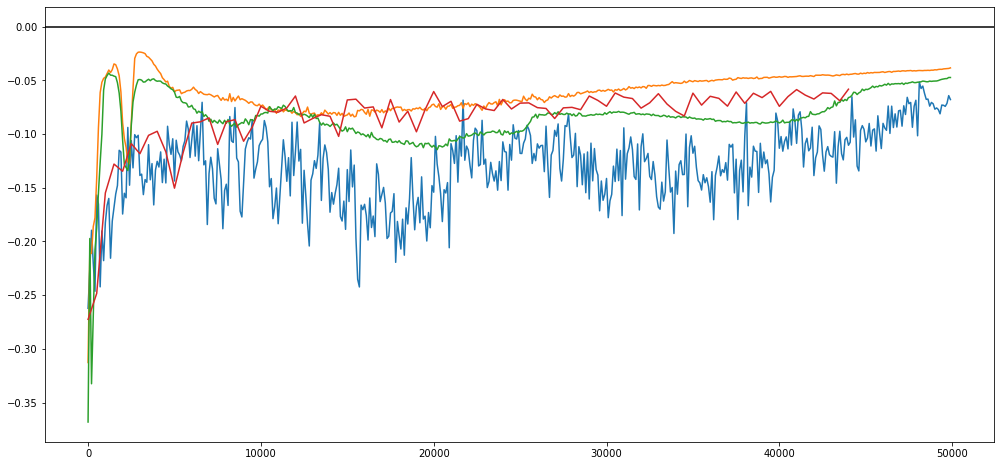

In [272]:
fig, ax = plt.subplots(figsize=(17, 8))
thresh = valus_opt / np.mean(portfolio,axis=0)[1]
for d in ds:
    ax.plot(d[0], ((d[1]/100-thresh)/thresh))
ax.axhline(0, color='black')    

In [15]:
vals, stds = calc_agent(ldr, 'DQN-0', portfolio, log_num=0, niter= 100, w_points = 100, l_points=100, lam_lim=5)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [22:38<00:00,  2.72s/it]


In [17]:
import time

In [20]:
now = time.time()

In [23]:
time.time() - now

19.337053537368774

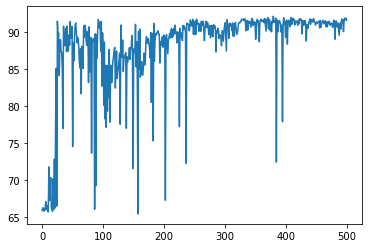

In [16]:
plt.plot(vals)

### END

In [137]:
vals = np.asarray(cython_pricer_optimized.value_account(np.array([0.2, 200]), ww, ll, p, cython_pricer_optimized.convert_params_obj(ag.env.params), ag.env.env.action_bins, n_iterations=10000))

In [138]:
np.mean(vals)

116.13722292772543

In [139]:
np.mean(vals_naive)

111.26565

In [14]:
%%timeit
agent.main_net.predict_on_batch(converted[None, :])

1.92 ms ± 36.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
%%timeit
agent.main_net(converted[None, :])

313 µs ± 6.35 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
%%timeit
agent.main_net.predict(converted[None, :])

27.5 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
np.argmax(agent.main_net.predict(agent.env.observation(point)[None, :]))

2

In [145]:
import logging, sys
logging.disable(sys.maxsize)

def checkpoints_and_paths(name):
    # name = "Vanilla4ActionsSplines50K"
    log_path = os.path.join(misc.RESOURCE_ROOT, 'models', name)
    logs = os.listdir(log_path)
    print(logs)
    log_num = 1
    checkpoints_path = os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[0], 'checkpoints')
    checkpoints = np.sort(np.array(os.listdir(checkpoints_path), dtype='int32'))
    checkpoints_paths = [os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[0], 'checkpoints', str(pasorted)) for pasorted in checkpoints]
    return checkpoints_paths

def plot_learning_performance(names):
    checkpoint_paths = [checkpoints_and_paths(name) for name in names]
    accounts = np.array([[1. , 200],[1. , 100], [1. , 50]])
    values = np.zeros((len(checkpoints), accounts.shape[0], len(names)))
    actions = np.zeros((len(checkpoints), accounts.shape[0], len(names)))
    agentf = load_agent_from_path(checkpoints_paths[-1])
    trans_acc = agentf.env.observation(accounts)
    for i, cp in enumerate(tqdm(checkpoint_paths[0][:200])):
        for j, n in enumerate(names):
            agent = load_agent_from_path(checkpoint_paths[j][i])
            values[i, :, j] = np.amax(agent.main_net.predict_on_batch(trans_acc), axis=1)
            actions[i, :, j] = np.argmax(agent.main_net.predict_on_batch(trans_acc), axis=1)
    return values , actions

In [146]:
vals, actions = plot_learning_performance(["Vanilla4ActionsSplines50K", "Penalized4ActionsSplines50K"])


['20201215-215946', '20201215-215951']
['20201215-214758', '20201215-215926']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:35<00:00,  2.10it/s]


Text(0.5, 1.0, 'Constrained vs NonConstrained')

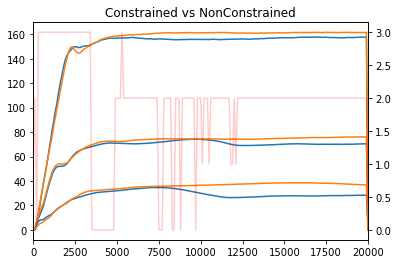

In [157]:
fig, ax = plt.subplots()
ax.plot(checkpoints, vals[:, 0, 0], color = 'C0')
ax.plot(checkpoints, vals[:, 0, 1], color = 'C1')
ax.plot(checkpoints, vals[:, 1, 0], color = 'C0')
ax.plot(checkpoints, vals[:, 1, 1], color = 'C1')
ax.plot(checkpoints, vals[:, 2, 0], color = 'C0')
ax.plot(checkpoints, vals[:, 2, 1], color = 'C1')
ax2 = ax.twinx()
ax2.plot(checkpoints, actions[:, 0, 0], color='red', alpha=0.2)
ax.set_xlim([0, 20000])
ax.set_title('Constrained vs NonConstrained')

In [125]:
import logging, sys
from tqdm import tqdm
logging.disable(sys.maxsize)

accounts = np.array([[1. , 200],[1. , 100], [1. , 50]])
values = np.zeros((len(checkpoints), accounts.shape[0]))
actions = np.zeros((len(checkpoints), accounts.shape[0]))
agentf = load_agent_from_path(checkpoints_paths[-1])
trans_acc = agentf.env.observation(accounts)
for i, cp in enumerate(tqdm(checkpoints)):
    agent = load_agent_from_path(checkpoints_paths[i])
    values[i, :] = np.amax(agent.main_net.predict_on_batch(trans_acc), axis=1)
    actions[i, :] = np.argmax(agent.main_net.predict_on_batch(trans_acc), axis=1)
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:00<00:00,  4.16it/s]


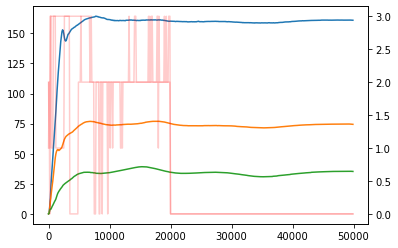

In [147]:
fig, ax = plt.subplots()
ax.plot(checkpoints, values[:, 0])
ax.plot(checkpoints, values[:, 1])
ax.plot(checkpoints, values[:, 2])
ax2 = ax.twinx()
ax2.plot(checkpoints, actions[:, 0], color='red', alpha=0.2)

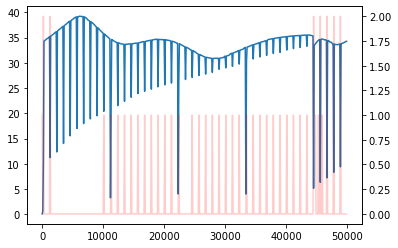

In [101]:
fig, ax = plt.subplots()
ax.plot(checkpoints, values[:, 1])
ax2 = ax.twinx()
ax2.plot(checkpoints, actions[:, 1], color='red', alpha=0.2)

In [ ]:
np.amax(agent.main_net.predict_on_batch(agent.env.observation(np.array([[1. , 100], [1. , 50]] ))), axis=1)

In [57]:
agent = load_agent_from_path(checkpoints_paths[2])

[INFO] [2021-02-04 12:50:13,158] [C:\Projects\credit_collections_rl\learning\resources\models\Vanilla4ActionsSplines50K\20201215-215951\checkpoints\1000] - Instantiated class DQNAgent
[WARNING] [2021-02-04 12:50:13,358] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
[WARNING] [2021-02-04 12:50:13,370] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


In [67]:
agent.env.observation(np.array([[1. , 100], [1. , 50]] ))

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.19624559e-02, 8.05528547e-03,
        7.98881254e-04, 1.67107415e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.75136485e-01, 1.85271566e-01,
        1.83742688e-02, 3.84347055e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.75136485e-01, 1.85271566e-01,
        1.83742688e-02, 3.84347055e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.19624559e-02, 8.05528547e-03,
        7.98881254e-04, 1.67107415e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [72]:
np.amax(agent.main_net.predict_on_batch(agent.env.observation(np.array([[1. , 100], [1. , 50]] ))), axis=1)

array([42.100174, 10.450637], dtype=float32)

In [58]:
def create_map(agent, lam_lim=7):
    w_points = 80
    l_points = 80
    l = np.linspace(agent.env.observation_space.low[0], lam_lim, l_points)
    w = np.linspace(agent.env.observation_space.low[1], agent.env.observation_space.high[1], w_points)
    
#     w_normalized = np.linspace(0, 1, w_points)
#     l_normalized = np.linspace(0, agent.env.observation((lam_lim,100))[0], l_points)
#     wwn, lln = np.meshgrid(w_normalized, l_normalized)
    ww, ll = np.meshgrid(w, l)
    space_iterator = product(l, w)
    space_product = agent.env.observation(np.array([[i, j] for i, j in space_iterator]))
    predictions = agent.main_net.predict_on_batch(space_product)
    z = np.amax(predictions, axis=1).reshape(l_points, w_points)
    p = np.argmax(predictions, axis=1).reshape(l_points, w_points)
    return  ww, ll, p, z
#ww, ll, aa, z = create_map(agent)
ww, ll, p, z = create_map(agent)

Text(0.5, 1.0, 'Simplest default with labels')

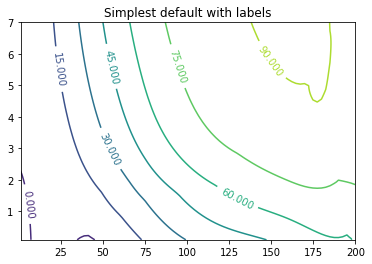

In [59]:
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')